In [38]:
import numpy as np

# maximal clique problem
# target function is xT*A*x + some regularization term
# with x being an n-dimensional simplex
# (feasible set consists of probability simplexes)
# and A - a {0,1} graph adjacency matrix

def maxclique_grad(A: np.ndarray, x: np.ndarray, penalty: str = 'l2', p: int = None, alpha: float = None, beta: float = None, eps: float = None):
    """
    Gradient calculation for the Maximal Clique.

    A: a R^NxN adjacency matrix;
    x: a R^N vector;
    penalty: {'l2', 'f1', 'f2'} string specifying the type of penalty to use; defaults to l2;
    p, alpha, beta, eps: penalty parameters.
    """
    dp = 2*x
    if str.lower(penalty) == 'f1':
        raise NotImplementedError
    if str.lower(penalty) == 'f2':
        if beta <= 0 or alpha < 0 or alpha >= (2/beta**2):
            raise ValueError
        dp = alpha*np.sum(-beta*np.exp(-beta*x))

    return np.dot((A + A.T), x) + dp

def maxclique_lmo(grad):
    """
    LMO for the maximal clique problem. 
    The feasible set is the unit simplex, so return a [0,...,1,...,0] vector with 1 in place of the lowest element of the gradient.
    """
    e = np.zeros(shape=grad.shape[-1])
    idxmin = np.argmin(grad)
    e[idxmin] = 1
    return e

def frankwolfe(A: np.ndarray, grad: callable, lmo: callable, max_iter: int, x_0:float, stepsize: float = None):
    '''
    Basic Frank-Wolfe algorithm.

    A: graph adjacency matrix;
    g: gradient f-n;
    stepsize: defaults to 2/(k+2), step defined as (1-stepsize)*x_k + stepsize*x_k_hat;
    max_iter: max. nr of iterations,
    x_0: starting point.
    '''
    x_hist = [x_0]
    s_hist = []
    for k in range(max_iter):
        s = lmo(grad(A, x_hist[-1]))
        gamma = 2/(k+2) if stepsize is None else stepsize
        x_next = (1-gamma)*x_hist[-1] + gamma*s

        x_hist.append(x_next)
        s_hist.append(s)
    return x_hist, s_hist


In [2]:
from matplotlib import pyplot as plt

In [3]:
def make_test_graph(n, p):
    r = [0,1]
    A = np.tril(np.random.default_rng().choice(a=r, size=(n,n),p=[1-p, p]), k=-1)
    A = A + A.T
    for i in range(n):
        A[i,i] = 1
    return A

def draw_graph(A):
    import networkx as nx
    A_ = np.copy(A)
    for i in range(A_.shape[0]):
        A_[i,i] = 0
    G = nx.Graph(A_)
    nx.draw(G, labels={i:f'{i}' for i in range(A.shape[0])})

In [4]:
A = np.array([
    [1,1,1,1,0],
    [1,1,0,0,1],
    [1,0,1,1,1],
    [1,0,1,1,1],
    [0,1,1,1,1]
])

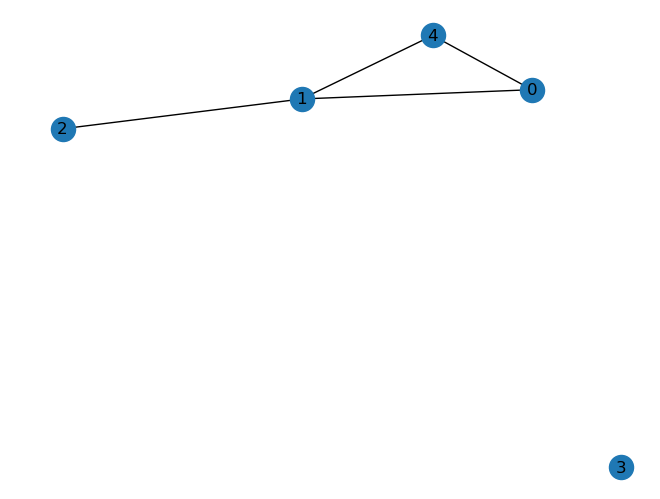

In [39]:
A = make_test_graph(5, 0.6)
draw_graph(A)

In [40]:
x_0 = np.ones_like(A[0]) + 0.
x_0 /= np.sum(x_0)
x_hist, s_hist = frankwolfe(A=A, grad=maxclique_grad, lmo=maxclique_lmo, max_iter=100000, x_0=x_0)

In [41]:
np.sum(np.abs(x_hist[-1]) >= 1e-5) 

4

In [333]:
x_0

array([0.2, 0.2, 0.2, 0.2, 0.2])